# Clone and install custom gym

In [8]:
# Clone and install Sigurds version of the gym
!git clone -b master_student_branch https://github.com/sigurdhjerde/gym.git

%cd gym/
!git branch

!ls
!pip install -e .

Cloning into 'gym'...
remote: Enumerating objects: 10116, done.
remote: Total 10116 (delta 0), reused 0 (delta 0), pack-reused 10116
Receiving objects: 100% (10116/10116), 5.17 MiB | 10.21 MiB/s, done.
Resolving deltas: 100% (6899/6899), done.
/content/gym
* master_student_branch
bin		     LICENSE.md		   scripts		  tox.ini
CODE_OF_CONDUCT.rst  Makefile		   setup.py		  unittest.cfg
docs		     README.rst		   test.dockerfile.14.04  vendor
examples	     requirements_dev.txt  test.dockerfile.16.04
gym		     requirements.txt	   test.dockerfile.18.04
Obtaining file:///content/gym
ERROR: stable-baselines 2.2.1 has requirement gym[atari,classic_control]>=0.10.9, but you'll have gym 0.10.8 which is incompatible.
  Found existing installation: gym 0.15.4
    Uninstalling gym-0.15.4:
      Successfully uninstalled gym-0.15.4
  Running setup.py develop for gym


# Import modules

In [0]:
import random
from collections import deque

import operator

import gym
import numpy as np

from gym.envs.diabetes.meal_generator.meal_generator import meal_generator

import torch as th
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Prioritized replay buffer class

In [0]:
class SegmentTree(object):
    def __init__(self, capacity, operation, neutral_element):
        """Build a Segment Tree data structure.
        https://en.wikipedia.org/wiki/Segment_tree
        Can be used as regular array, but with two
        important differences:
            a) setting item's value is slightly slower.
               It is O(lg capacity) instead of O(1).
            b) user has access to an efficient `reduce`
               operation which reduces `operation` over
               a contiguous subsequence of items in the
               array.
        Paramters
        ---------
        capacity: int
            Total size of the array - must be a power of two.
        operation: lambda obj, obj -> obj
            and operation for combining elements (eg. sum, max)
            must for a mathematical group together with the set of
            possible values for array elements.
        neutral_element: obj
            neutral element for the operation above. eg. float('-inf')
            for max and 0 for sum.
        """
        assert capacity > 0 and capacity & (capacity - 1) == 0, "capacity must be positive and a power of 2."
        self._capacity = capacity
        self._value = [neutral_element for _ in range(2 * capacity)]
        self._operation = operation

    def _reduce_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self._value[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self._operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )

    def reduce(self, start=0, end=None):
        """Returns result of applying `self.operation`
        to a contiguous subsequence of the array.
            self.operation(arr[start], operation(arr[start+1], operation(... arr[end])))
        Parameters
        ----------
        start: int
            beginning of the subsequence
        end: int
            end of the subsequences
        Returns
        -------
        reduced: obj
            result of reducing self.operation over the specified range of array elements.
        """
        if end is None:
            end = self._capacity
        if end < 0:
            end += self._capacity
        end -= 1
        return self._reduce_helper(start, end, 1, 0, self._capacity - 1)

    def __setitem__(self, idx, val):
        # index of the leaf
        idx += self._capacity
        self._value[idx] = val
        idx //= 2
        while idx >= 1:
            self._value[idx] = self._operation(
                self._value[2 * idx],
                self._value[2 * idx + 1]
            )
            idx //= 2

    def __getitem__(self, idx):
        assert 0 <= idx < self._capacity
        return self._value[self._capacity + idx]


class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(SumSegmentTree, self).__init__(
            capacity=capacity,
            operation=operator.add,
            neutral_element=0.0
        )

    def sum(self, start=0, end=None):
        """Returns arr[start] + ... + arr[end]"""
        return super(SumSegmentTree, self).reduce(start, end)

    def find_prefixsum_idx(self, prefixsum):
        """Find the highest index `i` in the array such that
            sum(arr[0] + arr[1] + ... + arr[i - i]) <= prefixsum
        if array values are probabilities, this function
        allows to sample indexes according to the discrete
        probability efficiently.
        Parameters
        ----------
        perfixsum: float
            upperbound on the sum of array prefix
        Returns
        -------
        idx: int
            highest index satisfying the prefixsum constraint
        """
        assert 0 <= prefixsum <= self.sum() + 1e-5
        idx = 1
        while idx < self._capacity:  # while non-leaf
            if self._value[2 * idx] > prefixsum:
                idx = 2 * idx
            else:
                prefixsum -= self._value[2 * idx]
                idx = 2 * idx + 1
        return idx - self._capacity


class MinSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(MinSegmentTree, self).__init__(
            capacity=capacity,
            operation=min,
            neutral_element=float('inf')
        )

    def min(self, start=0, end=None):
        """Returns min(arr[start], ...,  arr[end])"""

        return super(MinSegmentTree, self).reduce(start, end)


class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)


class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(self, size, alpha):
        """Create Prioritized Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        alpha: float
            how much prioritization is used
            (0 - no prioritization, 1 - full prioritization)
        See Also
        --------
        ReplayBuffer.__init__
        """
        super(PrioritizedReplayBuffer, self).__init__(size)
        assert alpha > 0
        self._alpha = alpha

        it_capacity = 1
        while it_capacity < size:
            it_capacity *= 2

        self._it_sum = SumSegmentTree(it_capacity)
        self._it_min = MinSegmentTree(it_capacity)
        self._max_priority = 1.0

    def push(self, *args, **kwargs):
        """See ReplayBuffer.store_effect"""
        idx = self._next_idx
        super(PrioritizedReplayBuffer, self).push(*args, **kwargs)
        self._it_sum[idx] = self._max_priority ** self._alpha
        self._it_min[idx] = self._max_priority ** self._alpha

    def _sample_proportional(self, batch_size):
        res = []
        for _ in range(batch_size):
            # TODO(szymon): should we ensure no repeats?
            mass = random.random() * self._it_sum.sum(0, len(self._storage) - 1)
            idx = self._it_sum.find_prefixsum_idx(mass)
            res.append(idx)
        return res

    def sample(self, batch_size, beta):
        """Sample a batch of experiences.
        compared to ReplayBuffer.sample
        it also returns importance weights and idxes
        of sampled experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        beta: float
            To what degree to use importance weights
            (0 - no corrections, 1 - full correction)
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        weights: np.array
            Array of shape (batch_size,) and dtype np.float32
            denoting importance weight of each sampled transition
        idxes: np.array
            Array of shape (batch_size,) and dtype np.int32
            idexes in buffer of sampled experiences
        """
        assert beta > 0

        idxes = self._sample_proportional(batch_size)

        weights = []
        p_min = self._it_min.min() / self._it_sum.sum()
        max_weight = (p_min * len(self._storage)) ** (-beta)

        for idx in idxes:
            p_sample = self._it_sum[idx] / self._it_sum.sum()
            weight = (p_sample * len(self._storage)) ** (-beta)
            weights.append(weight / max_weight)
        weights = np.array(weights)
        encoded_sample = self._encode_sample(idxes)
        return tuple(list(encoded_sample) + [weights, idxes])

    def update_priorities(self, idxes, priorities):
        """Update priorities of sampled transitions.
        sets priority of transition at index idxes[i] in buffer
        to priorities[i].
        Parameters
        ----------
        idxes: [int]
            List of idxes of sampled transitions
        priorities: [float]
            List of updated priorities corresponding to
            transitions at the sampled idxes denoted by
            variable `idxes`.
        """
        assert len(idxes) == len(priorities)
        for idx, priority in zip(idxes, priorities):
            assert priority > 0
            assert 0 <= idx < len(self._storage)
            self._it_sum[idx] = priority ** self._alpha
            self._it_min[idx] = priority ** self._alpha

            self._max_priority = max(self._max_priority, priority)

# Noisy network

In [0]:
class NoisyLinear(nn.Module):
  def __init__(self, in_features, out_features, sigma_init=0.4):
    super(NoisyLinear, self).__init__()

    self.in_features  = in_features
    self.out_features = out_features
    self.sigma_init   = sigma_init

    self.weight_mu    = nn.Parameter(th.FloatTensor(out_features, in_features))
    self.weight_sigma = nn.Parameter(th.FloatTensor(out_features, in_features))
    self.register_buffer('weight_epsilon', th.FloatTensor(out_features, in_features))

    self.bias_mu    = nn.Parameter(th.FloatTensor(out_features))
    self.bias_sigma = nn.Parameter(th.FloatTensor(out_features))
    self.register_buffer('bias_epsilon', th.FloatTensor(out_features))

    self.reset_parameters()
    self.reset_noise()


  def forward(self, x):
    if self.training:
      weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
      bias   = self.bias_mu + self.bias_sigma * self.bias_epsilon
    else:
      weight = self.weight_mu
      bias   = self.bias_mu
    
    return F.linear(x, weight, bias)
  

  def reset_parameters(self):
    mu_range = 1 / np.sqrt(self.weight_mu.size(1))

    self.weight_mu.data.uniform_(-mu_range, mu_range)
    self.weight_sigma.data.fill_(self.sigma_init / np.sqrt(self.weight_sigma.size(1)))

    self.bias_mu.data.uniform_(-mu_range, mu_range)
    self.bias_sigma.data.fill_(self.sigma_init / np.sqrt(self.bias_sigma.size(0)))
  

  def reset_noise(self):
    epsilon_in  = self._scale_noise(self.in_features)
    epsilon_out = self._scale_noise(self.out_features)

    self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
    self.bias_epsilon.copy_(self._scale_noise(self.out_features))


  def _scale_noise(self, size):
    x = th.randn(size)
    x = x.sign() * x.abs().sqrt()
    return x

# C-51 algorithm

In [0]:
class CategoricalDQN(nn.Module):
  def __init__(self, N_states, N_actions, N_atoms, V_min, V_max):
    super(CategoricalDQN, self).__init__()

    self.N_actions = N_actions
    self.N_atoms   = N_atoms
    self.V_min     = V_min
    self.V_max     = V_max

    self.l1 = nn.Linear(N_states, 64)
    self.l2 = nn.Linear(64, 64)
    self.n1 = NoisyLinear(64, 64)
    self.n2 = NoisyLinear(64, 64)
    self.n3 = NoisyLinear(64, N_actions * N_atoms)

    self.layers = nn.Sequential(
        self.l1,
        nn.ReLU(),
        self.l2,
        nn.ReLU(),
        self.n1,
        nn.ReLU(),
        self.n2,
        nn.ReLU(),
        self.n3
    )

  
  def forward(self, x):
    y = self.layers(x)
    return F.softmax(y.view(-1, self.N_atoms)).view(-1, self.N_actions, self.N_atoms)

  
  def reset_noise(self):
    self.n1.reset_noise()
    self.n2.reset_noise()
    self.n3.reset_noise()
  

  def choose_action(self, state):
    state = th.FloatTensor(state).unsqueeze(0)
    support = th.linspace(self.V_min, self.V_max, self.N_atoms)
    dist = self.forward(state).data * support
    return dist.sum(2).max(1)[1].numpy()[0]

In [0]:
def projection_distribution(next_state, rewards, dones):
  batch_size = next_state.size(0)

  delta_z = float(V_max - V_min) / (N_atoms - 1)
  support = th.linspace(V_min, V_max, N_atoms)

  next_dist   = model_target(next_state).data * support
  next_action = next_dist.sum(2).max(1)[1].unsqueeze(1).unsqueeze(1)
  next_action = next_action.expand(next_dist.size(0), 1, next_dist.size(2))
  next_dist   = next_dist.gather(1, next_action).squeeze(1)

  rewards = rewards.unsqueeze(1).expand_as(next_dist)
  dones   = dones.unsqueeze(1).expand_as(next_dist)
  support = support.unsqueeze(0).expand_as(next_dist)

  T_z = rewards + (1 - dones) * gamma * support
  T_z = T_z.clamp(min = V_min, max = V_max)
  b   = (T_z - V_min) / delta_z
  l   = b.floor().long()
  u   = b.ceil().long()

  offset = th.linspace(0, (batch_size - 1) * N_atoms, batch_size).long()\
                    .unsqueeze(1).expand(batch_size, N_atoms)

  proj_dist = th.zeros(next_dist.size())
  proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
  proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1))

  return proj_dist

# Initiate environment

In [14]:
env_id = 'HovorkaCambridge-v1'
db = gym.make(env_id)

/content/gym/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


# Hyperparameters

In [0]:
N_states = db.observation_space.shape[0]
N_actions = db.action_space.n

N_atoms = 51
V_min = -10
V_max = 10

learning_rate = 1e-3
buffer_size = int(1e5)
batch_size = 512
gamma = 0.99
max_steps = int(1e5)

epsilon = 0.01

In [0]:
model_local  = CategoricalDQN(N_states, N_actions, N_atoms, V_min, V_max)
model_target = CategoricalDQN(N_states, N_actions, N_atoms, V_min, V_max)

optimizer     = optim.Adam(model_local.parameters(), lr=learning_rate)
replay_buffer = ReplayBuffer(buffer_size)

## Target network update

In [0]:
def update_target(model_local, model_target):
  model_target.load_state_dict(model_local.state_dict())

update_target(model_local, model_target)

# Learn function

In [0]:
def learn(batch_size):
  state, action, reward, next_state, done = replay_buffer.sample(batch_size)

  state      = th.FloatTensor(np.float32(state))
  action     = th.LongTensor(action)
  reward     = th.FloatTensor(reward)
  next_state = th.FloatTensor(np.float32(next_state))
  done       = th.FloatTensor(done)

  proj_dist = projection_distribution(next_state, reward, done)

  dist = model_local(state)
  action = action.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, N_atoms)
  dist = dist.gather(1, action).squeeze(1)
  dist.data.clamp_(epsilon, gamma)

  loss_train = -(proj_dist * dist.log()).sum(1).mean()

  optimizer.zero_grad()
  loss_train.backward()
  optimizer.step()

  model_local.reset_noise()
  model_target.reset_noise()

  return loss_train

# Train model

In [19]:
loss_list      = []
reward_list    = []
epsiode_reward = 0
episode_count  = 0

meals, meal_indicator = meal_generator()
db.env.meals          = meals
db.env.meal_indicator = meal_indicator

state = db.reset()

for t in range(1, max_steps + 1):
  action = model_local.choose_action(state)
  next_state, reward, done, _ = db.step(action)

  replay_buffer.push(state, action, reward, next_state, done)

  state = next_state
  epsiode_reward += reward

  if done:
    meals, meal_indicator = meal_generator()
    db.env.meals          = meals
    db.env.meal_indicator = meal_indicator

    state = db.reset()

    reward_list.append(epsiode_reward)
    epsiode_reward = 0
    episode_count += 1

    if episode_count % 100 == 0:
      print("Episode: {}".format(episode_count))
      print("Time step: {}".format(t))
      print("Mean 100 episode reward: {}".format(np.mean(reward_list[-100:])))
  

  if replay_buffer.__len__() > batch_size:
    loss_train = learn(batch_size)
    loss_list.append(loss_train.item())
  
  if t % 100 == 0:
    update_target(model_local, model_target)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode: 100
Time step: 6654
Mean 100 episode reward: 11.154990682516619
Episode: 200
Time step: 13854
Mean 100 episode reward: 44.33109350525171
Episode: 300
Time step: 21054
Mean 100 episode reward: 41.824220717630006
Episode: 400
Time step: 28254
Mean 100 episode reward: 38.82690213568152
Episode: 500
Time step: 35454
Mean 100 episode reward: 38.0549458276224
Episode: 600
Time step: 42654
Mean 100 episode reward: 39.33908175861023
Episode: 700
Time step: 49854
Mean 100 episode reward: 39.66467948289649
Episode: 800
Time step: 57054
Mean 100 episode reward: 38.26463787443385
Episode: 900
Time step: 64254
Mean 100 episode reward: 39.27980921751359
Episode: 1000
Time step: 71454
Mean 100 episode reward: 35.59258603491085
Episode: 1100
Time step: 78654
Mean 100 episode reward: 36.34556936992384
Episode: 1200
Time step: 85854
Mean 100 episode reward: 38.30611927454969
Episode: 1300
Time step: 93054
Mean 100 episode reward: 37.494771178552426


# Plots

## Test episode

In [0]:
def test_episode(model):
  done = False
  meals, meal_indicator = meal_generator()
  db.env.meals          = meals
  db.env.meal_indicator = meal_indicator

  db.env.reset_basal_manually = db.env.init_basal_optimal
  state = db.reset()
  action_list = []

  while not done:
    action = model.choose_action(state)
    state, reward, done, _ = db.step(action)

    action_list.append(action)
  
  bg_hist = db.env.bg_history

  plt.figure()
  plt.plot(bg_hist)
  plt.title('Test episode')
  plt.xlabel('Time')
  plt.ylabel('Blood glucose')
  plt.axhline(y=70, c='red', ls='--', alpha=0.9)
  plt.axhline(y=180, c='red', ls='--', alpha=0.9)
  plt.show()

  plt.figure()
  plt.plot(action_list)
  plt.title('Actions taken over time')
  plt.xlabel('Time')
  plt.ylabel('Actions')
  plt.show()

  TAR = sum(bg_hist > 180)/len(bg_hist) * 100
  TBR = sum(bg_hist < 70)/len(bg_hist) * 100
  TIR = 100 - (TAR + TBR)
      
  print("TIR: {}%".format(round(TIR, 2)))

  return bg_hist, np.array(action_list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


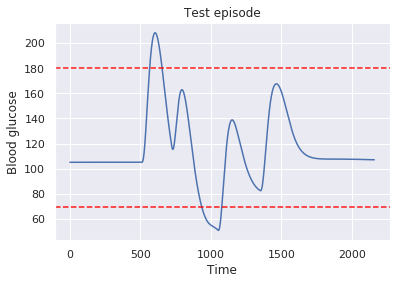

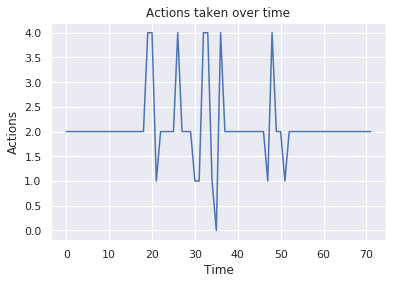

TIR: 89.31%


In [42]:
bg_hist_test, action_list_test = test_episode(model_local)

In [0]:
import csv

#Save test episode with actions
np.savetxt("bg_hist_test.csv", bg_hist_test, delimiter=",")
np.savetxt("actions_test.csv", action_list_test, delimiter=",")

## Learning curve 

In [0]:
def learning_curve(rewards):
  y = rewards
  w = np.ones(50)

  y_w = 2*y[0] - np.flip(y[0:50], 0)
  y_w = np.concatenate([y_w, np.asarray(y[:])])
  y_w = np.concatenate([y_w, 2*y[-1] - np.flip(y[-1-50:-1], 0)])

  y_smooth = np.convolve(y_w, w/sum(w))

  idx = int(np.floor(1.5*50))
  reward_smooth = y_smooth[idx:-1-idx-2]

  plt.figure()
  plt.plot(y)
  plt.plot(reward_smooth)
  plt.title("Learning curve")
  plt.xlabel("Episodes")
  plt.ylabel("Returns")
  plt.legend(["Learning curve", "Learning curve smoothed"], loc='best')

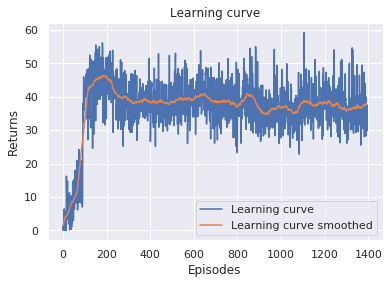

In [26]:
learning_curve(reward_list)

In [0]:
# Save all rewards
np.savetxt("dqn_rewards.csv", reward_list, delimiter=",")

## Mean blood glucose history

In [0]:
def mean_bg_history(model):
  bg_list = []

  for i in range(100):
    done = False
    meals, meal_indicator = meal_generator()
    db.env.meals = meals
    db.env.meal_indicator = meal_indicator

    db.env.reset_basal_manually = db.env.init_basal_optimal        
    state = db.reset()

    while not done:
      action = model.choose_action(state)
      state, reward, done, _ = db.step(action)
    
    bg_list.append(db.env.bg_history)

  mean_bg_min = np.mean(bg_list, 0)
  std_bg_min  = np.std(bg_list, 0)
  mean_bg_epi = np.mean(bg_list, 1)
  std_bg_epi  = np.std(bg_list, 1)

  low_bound = mean_bg_min - std_bg_min
  high_bound = mean_bg_min + std_bg_min

  bg_low  = 70
  bg_high = 180

  TBR = sum(mean_bg_min < bg_low)/len(mean_bg_min) * 100
  TAR = sum(mean_bg_min > bg_high)/len(mean_bg_min) * 100
  TIR = 100 - (TBR + TAR)

  plt.figure()
  plt.plot(mean_bg_min)
  plt.fill_between(np.linspace(0, 2160, 2160), low_bound, high_bound,
                   alpha=0.3, edgecolor='#1B2ACC', facecolor='#089FFF')
  plt.title('Mean blood glucose per minute')
  plt.xlabel('Time steps')
  plt.ylabel('Blood glucose')
  plt.axhline(y = bg_low, c='red', ls='--', alpha=0.9)
  plt.axhline(y = bg_high, c='red', ls='--', alpha=0.9)
  plt.show()

  print("TBR: {}%".format(round(TBR, 2)))
  print("TAR: {}%".format(round(TAR, 2)))
  print("TIR: {}%".format(round(TIR, 2)))

  return mean_bg_min, low_bound, high_bound, mean_bg_epi, std_bg_epi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


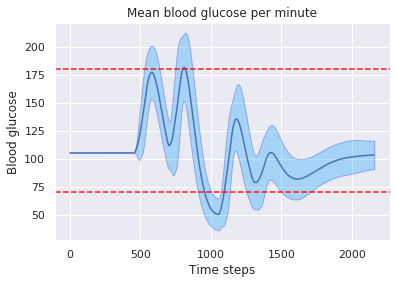

TBR: 6.39%
TAR: 0.83%
TIR: 92.78%


(105.89597853941893, 33.96368541506601)

In [55]:
mean_bg_min, low_bound, high_bound, mean_bg_epi, std_bg_epi = mean_bg_history(model_local)
np.mean(mean_bg_epi), np.mean(std_bg_epi)

In [0]:
# Save mean BG per minute and boundaries
np.savetxt("mean_bg_min.csv", mean_bg_min, delimiter=",")
np.savetxt("low_bound.csv", low_bound, delimiter=",")
np.savetxt("high_bound.csv", high_bound, delimiter=",")

## Time-in-range

In [0]:
def time_in_range(model):
  bg_low  = 70
  bg_high = 180

  TBR_list = []
  TAR_list = []
  TIR_list = []

  for i in range(14):
    done = False
    meals, meal_indicator = meal_generator()
    db.env.meals          = meals
    db.env.meal_indicator = meal_indicator

    db.env.reset_basal_manually = db.env.init_basal_optimal
    state = db.reset()

    while not done:
      action = model.choose_action(state)
      state, reward, done, _ = db.step(action)
    
    bg_hist = db.env.bg_history

    TBR = sum(bg_hist < bg_low)/len(bg_hist) * 100
    TAR = sum(bg_hist > bg_high)/len(bg_hist) * 100
    TIR = 100 - (TBR + TAR)

    TBR_list.append(TBR)
    TAR_list.append(TAR)
    TIR_list.append(TIR)

  print("Mean TIR: {}%".format(round(np.mean(TIR_list), 2)))
  print("Mean TAR: {}%".format(round(np.mean(TAR_list), 2)))
  print("Mean TBR: {}%".format(round(np.mean(TBR_list), 2)))

In [69]:
time_in_range(model_local)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Mean TIR: 84.2%
Mean TAR: 4.96%
Mean TBR: 10.84%


## Skip meals

In [0]:
def mean_bg_history_meal_skip(model):
  # Test meals with a set seed
  todays_seed = 150
  n_test_scenarios = 100

  bg_list = []
  actions_epi = []
  action_list = []

  for k in range(n_test_scenarios):
    m = meal_generator(seed=todays_seed + k)
    db.env.meals = m[0]

    # With some probability skip a bolus at random
    if np.random.rand() < .1:
      m[1][np.random.choice(np.squeeze(np.nonzero(m[1])))] = 0
  
    db.env.meal_indicator = m[1]

    db.env.reset_basal_manually = db.env.init_basal_optimal
    state = db.reset()
    for i in range(72):
      action = model.choose_action(state)
      state, reward, done, _ = db.step(action)

      actions_epi.append(action)
    
    for i in range(len(actions_epi)):
      if actions_epi[i] == 1:
        actions_epi[i] = 6.43
      elif actions_epi[i] == 2:
        actions_epi[i] = 3*6.43
  
    bg_list.append(db.env.bg_history)
    action_list.append(actions_epi)

  mean_bg_min = np.mean(bg_list, 0)
  std_bg_min  = np.std(bg_list, 0)
  mean_bg_epi = np.mean(bg_list, 1)
  std_bg_epi  = np.std(bg_list, 1)

  low_bound = mean_bg_min - std_bg_min
  high_bound = mean_bg_min + std_bg_min

  bg_low  = 70
  bg_high = 180

  TBR = sum(mean_bg_min < bg_low)/len(mean_bg_min) * 100
  TAR = sum(mean_bg_min > bg_high)/len(mean_bg_min) * 100
  TIR = 100 - (TBR + TAR)

  plt.figure()
  plt.plot(mean_bg_min)
  plt.fill_between(np.linspace(0, 2160, 2160), low_bound, high_bound,
                   alpha=0.3, edgecolor='#1B2ACC', facecolor='#089FFF')
  plt.title('Mean blood glucose per minute')
  plt.xlabel('Time steps')
  plt.ylabel('Blood glucose')
  plt.axhline(y = bg_low, c='red', ls='--', alpha=0.9)
  plt.axhline(y = bg_high, c='red', ls='--', alpha=0.9)
  plt.show()

  print("TBR: {}%".format(round(TBR, 2)))
  print("TAR: {}%".format(round(TAR, 2)))
  print("TIR: {}%".format(round(TIR, 2)))

  mean_action_epi = np.mean(action_list, 1)
  std_action_epi = np.std(action_list, 1)

  return mean_bg_min, low_bound, high_bound, mean_bg_epi, std_bg_epi, mean_action_epi, std_action_epi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


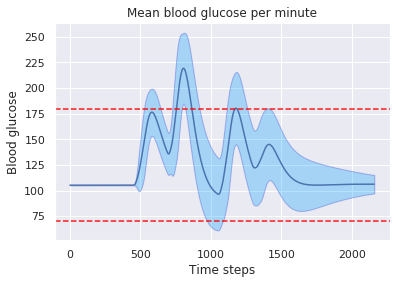

TBR: 0.0%
TAR: 5.51%
TIR: 94.49%


(125.95479605670491, 36.466231637426155)

In [0]:
mean_bg_min_ms, low_bound_ms, high_bound_ms, mean_bg_epi_ms, std_bg_epi_ms, mean_action_epi_ms, std_action_epi_ms = mean_bg_history_meal_skip(model_local)

np.mean(mean_bg_epi_ms), np.mean(std_bg_epi_ms)

In [0]:
np.mean(mean_action_epi_ms), np.mean(std_action_epi_ms)

(6.43, 8.881784197001252e-16)

In [0]:
# Save mean BG per minute and boundaries when doing meal skips
np.savetxt("mean_bg_min_ms.csv", mean_bg_min_ms, delimiter=",")
np.savetxt("low_bound_ms.csv", low_bound_ms, delimiter=",")
np.savetxt("high_bound_ms.csv", high_bound_ms, delimiter=",")